In [1]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize

In [2]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [3]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["assets","liabilities","reference_price"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [4]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = p.column_date_processing(sec.query("filings",{"cik":cik}))
        filings["year"] = [x.year + 1 for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        # filings["year"] = [x.year if x.quarter < 4 else x.year + 1 for x in filings["date"]]
        # filings["quarter"] = [x.quarter + 1 if x.quarter < 4 else 1 for x in filings["date"]]
        ticker_factors = filings.drop(["date","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
        ticker_factors["ticker"] = ticker
        ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
        ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
        factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

26it [00:01, 17.01it/s]

AMTM 'date'


63it [00:03, 18.70it/s]

BRK.B 'date'


67it [00:04, 17.81it/s]

BLK 'date'


78it [00:04, 16.60it/s]

BF.B 'date'


502it [00:30, 16.26it/s]

ZTS 'date'


In [5]:
factors_df.sort_values(["ticker","year","quarter"])

,year,quarter,ticker,adjclose,y,assets,liabilities,reference_price
0,2014,1,A,37.984034,37.120989,1.059450e+10,5.326500e+09,NaN
1,2014,2,A,37.120989,37.846924,1.056150e+10,5.315000e+09,37.984034
2,2014,3,A,37.846924,37.250024,1.040700e+10,5.419500e+09,37.120989
3,2014,4,A,37.250024,37.340297,1.061100e+10,5.374000e+09,37.846924
4,2015,1,A,37.340297,38.407948,1.066200e+10,5.294000e+09,37.250024
...,...,...,...,...,...,...,...,...
42,2024,3,ZBRA,335.879531,387.112069,7.492500e+09,4.630000e+09,304.088016
43,2024,4,ZBRA,387.112069,NaN,7.430000e+09,4.557000e+09,335.879531
44,2025,1,ZBRA,NaN,NaN,7.417500e+09,4.533000e+09,387.112069
45,2025,2,ZBRA,NaN,NaN,7.282500e+09,4.180000e+09,NaN


In [6]:
model = XGBRegressor()
factors_df = factors_df.dropna(subset=factors)
training_data = factors_df[(factors_df["year"]>=2013) & (factors_df["year"]<2020)].dropna()
sim = factors_df[(factors_df["year"]>=2019)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["year","quarter","ticker","prediction"]]

In [7]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left").merge(macro,on="date",how="left")
        price["factor"] = price["prediction"] / price["adjclose"] - 1
        # price = CAPM.apply(price)
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 13%|███████████████████▌                                                                                                                                     | 64/502 [00:03<00:27, 16.22it/s]

'date'


 15%|███████████████████████▍                                                                                                                                 | 77/502 [00:04<00:22, 18.56it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:29<00:00, 17.04it/s]

'date'


In [8]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left")
simulation = simulation[(simulation["year"]>=2020)].dropna()

In [9]:
tickers = list(simulation[simulation["year"]==2020]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

In [10]:
simulation["rank"] = simulation.groupby(["date","GICS Sector"])["factor"].rank(method="dense",ascending=False).astype(int)

In [11]:
simulation["exposure"] = [1 if x <= simulation["rank"].max() * 0.1 or x > simulation["rank"].max() * 0.90 else 1.0/6.0 for x in simulation["rank"]]

In [12]:
simulation["projected"] = simulation["factor"] * simulation["exposure"]

In [13]:
simulation["sell_price"] = simulation["adjclose"]
simulation.sort_values("date",inplace=True)
trades = simulation[["year","quarter","GICS Sector","ticker","projected","exposure","adjclose","sell_price"]].groupby(["year","quarter","ticker"]).agg({"GICS Sector":"first","projected":"first","exposure":"first","adjclose":"first","sell_price":"last"}).reset_index()
trades = trades.sort_values("projected",ascending=False).groupby(["year","quarter","GICS Sector"]).first().reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"]
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()

In [14]:
trades.sort_values("return",ascending=False).head(40)

,year,quarter,GICS Sector,ticker,projected,exposure,adjclose,sell_price,return
12,2020,2,Consumer Discretionary,CZR,3.670344,1.0,11.690000,40.060000,2.426861
133,2023,1,Consumer Discretionary,TSLA,1.080965,1.0,108.100000,207.460000,0.919149
19,2020,2,Materials,FCX,1.022221,1.0,6.033135,11.062341,0.833597
17,2020,2,Industrials,BLDR,1.378208,1.0,11.480000,20.700000,0.803136
18,2020,2,Information Technology,ON,1.073650,1.0,11.000000,19.820000,0.801818
14,2020,2,Energy,FANG,1.675174,1.0,20.254980,34.123210,0.684683
29,2020,3,Information Technology,ENPH,0.342267,1.0,49.060000,82.590000,0.683449
36,2020,4,Energy,FANG,0.383396,1.0,23.935821,40.267288,0.682302
144,2023,2,Consumer Discretionary,NCLH,0.219298,1.0,13.350000,21.770000,0.630712
15,2020,2,Financials,DFS,1.178778,1.0,28.199222,45.279221,0.605690


In [15]:
trades.iloc[-505:].to_csv("current.csv")

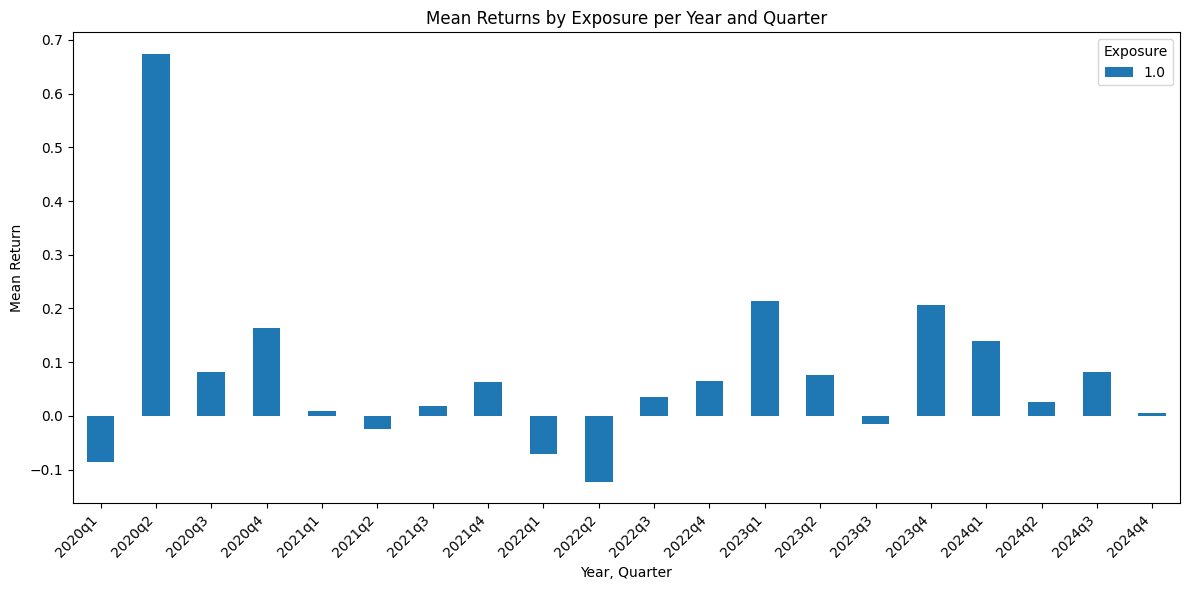

In [16]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
macro["year"] = [x.year for x in macro["date"]]
macro["quarter"] = [x.quarter for x in macro["date"]]
benchmark = macro.drop(["date","realtime_start","realtime_end"],axis=1).groupby(["year","quarter"]).mean().reset_index()
benchmark["sp500"] = benchmark["sp500"] / benchmark["sp500"].iloc[0] - 1
benchmark["rf"] = benchmark["rf"] / benchmark["rf"].iloc[0] - 1
benchmark["sp500_prediction"] = benchmark["sp500_prediction"] / benchmark["sp500_prediction"].iloc[0] - 1

In [18]:
benchmark

,year,quarter,sp500,sp500_prediction,rf
0,2019,1,0.000000,0.000000,0.000000
1,2019,2,0.059288,0.026727,-0.118382
2,2019,3,0.087044,0.066649,-0.322276
3,2019,4,0.132948,0.064636,-0.345658
4,2020,1,0.123067,-0.021868,-0.485479
5,2020,2,0.077428,0.063248,-0.740810
6,2020,3,0.220077,-0.037248,-0.754754
7,2020,4,0.306320,-0.048885,-0.684314
8,2021,1,0.420691,-0.069597,-0.496447
9,2021,2,0.537530,-0.136081,-0.401146


In [19]:
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")

<Axes: title={'center': 'Mean Returns by Exposure per Year and Quarter'}, xlabel='Year-Quarter'>

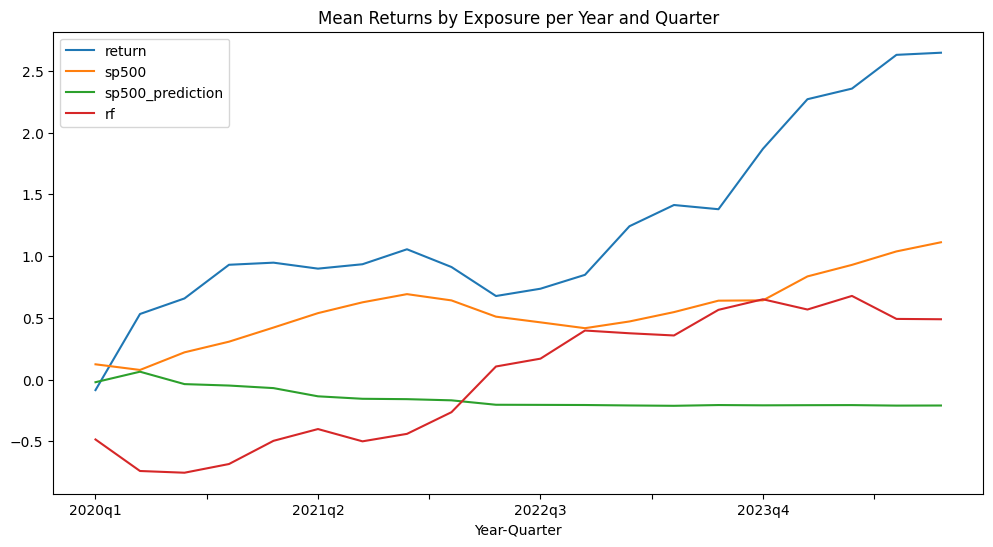

In [20]:
portfolio.drop(["year","quarter"],axis=1,inplace=True)
portfolio.set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

In [21]:
trades.groupby(["year","quarter","GICS Sector"]).agg({"return":"mean"}).tail(20)

return
year quarter GICS Sector                     
2024 3       Consumer Staples        0.058580
             Energy                  0.003842
             Financials              0.072866
             Health Care            -0.005468
             Industrials             0.266478
             Information Technology -0.044389
             Materials               0.013192
             Real Estate             0.174511
             Utilities               0.185748
     4       Communication Services  0.034215
             Consumer Discretionary -0.053201
             Consumer Staples        0.018521
             Energy                  0.093173
             Financials              0.024860
             Health Care             0.024687
             Industrials             0.002190
             Information Technology -0.014728
             Materials              -0.014506
             Real Estate            -0.014111
             Utilities              -0.048914

In [22]:
sim

,year,quarter,ticker,prediction
20,2019,1,MMM,137.650040
20,2019,1,AOS,43.529072
15,2019,1,ADBE,280.967529
20,2019,1,AFL,39.585457
20,2019,1,A,66.725746
...,...,...,...,...
44,2025,1,YUM,132.201889
44,2025,1,ZBRA,417.816437
44,2025,1,ZBH,117.049202
39,2025,2,KR,60.321709
